# YouTube Live Capture
> This module is used to capture images from YouTube live.

In [ ]:
#|default_exp ninjalabo.llmcam.ytlive

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export
import yt_dlp as youtube_dl

In [ ]:
#|eval: false

youtube_live_url = "https://www.youtube.com/watch?v=LMZQ7eFhm58"
ydl_opts = {
    'cookiefile': "cookies.txt",  # Path to the exported cookies file,  # Use cookies for authentication
    'download': False  # Set to True if you want to download
}

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    info = ydl.extract_info(youtube_live_url, download=False)
    for o in info['formats']:
        if o['resolution'] == '1280x720':
            print(o['url'])
            break
    else:
        raise ValueError("No 1280x720 format")

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading web creator player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
https://manifest.googlevideo.com/api/manifest/hls_playlist/expire/1730238055/ei/BgIhZ_r_O62Nv_IP_9Gj6Qc/ip/87.92.255.37/id/LMZQ7eFhm58.4/itag/232/source/yt_live_broadcast/requiressl/yes/ratebypass/yes/live/1/sgovp/gir%3Dyes%3Bitag%3D136/rqh/1/hdlc/1/hls_chunk_host/rr5---sn-qo5-ixas.googlevideo.com/xpc/EgVo2aDSNQ%3D%3D/playlist_duration/3600/manifest_duration/3600/vprv/1/playlist_type/DVR/initcwndbps/1805000/met/1730216455,/mh/l8/mm/44/mn/sn-qo5-ixas/ms/lva/mv/m/mvi/5/pl/18/rms/lva,lva/dover/13/pacing/0/short_key/1/keepalive/yes/fexp/51312688,51326931/mt/1730215971/sparams/expire,ei,ip,id,itag,source,requiressl,ratebypass,live,sgovp,rqh,hdlc,xpc,playlist_duration,manifest_duration,vprv,playlist_type/sig/AJfQd

In [ ]:
def stream_url(ytlive_url, ydl_opts):
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(youtube_live_url, download=False)
        for o in info['formats']:
            if o['resolution'] == '1280x720':
                return o['url']
        else:
            raise ValueError("No 1280x720 format")    

In [ ]:
#|eval: false
stream_url(youtube_live_url, ydl_opts)

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading web creator player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information


'https://manifest.googlevideo.com/api/manifest/hls_playlist/expire/1730238055/ei/BwIhZ4WoL-6Nv_IP16OjkQY/ip/87.92.255.37/id/LMZQ7eFhm58.4/itag/232/source/yt_live_broadcast/requiressl/yes/ratebypass/yes/live/1/sgovp/gir%3Dyes%3Bitag%3D136/rqh/1/hdlc/1/hls_chunk_host/rr5---sn-qo5-ixas.googlevideo.com/xpc/EgVo2aDSNQ%3D%3D/playlist_duration/3600/manifest_duration/3600/vprv/1/playlist_type/DVR/initcwndbps/1805000/met/1730216455,/mh/l8/mm/44/mn/sn-qo5-ixas/ms/lva/mv/m/mvi/5/pl/18/rms/lva,lva/dover/13/pacing/0/short_key/1/keepalive/yes/fexp/51312688,51326932/mt/1730215971/sparams/expire,ei,ip,id,itag,source,requiressl,ratebypass,live,sgovp,rqh,hdlc,xpc,playlist_duration,manifest_duration,vprv,playlist_type/sig/AJfQdSswRgIhAJq9S0ykOqyR2LLzoV67I3yVWwujTwCgzvEEphwbi7pnAiEA8QHtulYsuDUB3pQpNtT1QmmEVEf3Is4RdOzgcHr1RJY%3D/lsparams/hls_chunk_host,initcwndbps,met,mh,mm,mn,ms,mv,mvi,pl,rms/lsig/ACJ0pHgwRQIhANi7xWUWUODcHZywXVTqzprgBj2KJg-hq7cb0gYTErmZAiA96tOuVeCVspB7TSOBTDuy3wqwYs-C8TanMhLqsNzJ1Q%3D%3D/

In [ ]:
from datetime import datetime
datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

'2024-10-29_17:40:55'

In [ ]:
def capture_frame(ytlive_url, crop_region=None):
    """Capture a frame from the live stream with cropped a region"""
    cap = cv2.VideoCapture(stream_url(htlive_url))
    if not cap.isOpened():
        print("Error: Could not open video stream.")
        return None
    ret, frame = cap.read()
    if ret:
        if crop_region:
            x,y,w,h = crop_region
            frame = frame[y:y+h, x:x+w]
        #path = Path("../data")/("frame_" + str(int(time.time())) + ".jpg")
        path = ("frame_" + str(int(time.time())) + ".jpg")
        cv2.imwrite(path, frame)
        print(path)
        return path
    else:
        print("Error: Could not capture frame.")
        return None

In [ ]:
#|export
import cv2
import yt_dlp as youtube_dl
import time
from IPython.display import Image, display
from pathlib import Path

class YouTubeLive:
    def __init__(self, url="https://www.youtube.com/watch?v=LMZQ7eFhm58"):
        self.youtube_live_url = url
        self.stream_live_url = self.stream_url(url)
    
    def stream_url(self, youtube_live_url):
        assert self.youtube_live_url != None, "self.youtube_live_url == None"
        with youtube_dl.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(youtube_live_url, download=False)
            for o in info['formats']:
                if o['resolution'] == '1280x720':
                    return o['url']
            raise ValueError("No 1280x720 format")
            return None
    
    def capture_frame(self, crop_region=None):
        """Capture a frame from the live stream with cropped a region"""
        assert self.stream_live_url != None
        cap = cv2.VideoCapture(self.stream_live_url)
        if not cap.isOpened():
            print("Error: Could not open video stream.")
            return None
    
        ret, frame = cap.read()
        if ret:
            if crop_region:
                x, y, w, h = crop_region
                frame = frame[y:y+h, x:x+w]
            path = Path("../data")/("frame_" + str(int(time.time())) + ".jpg")
            cv2.imwrite(path, frame)
            print(path)
            return path
        else:
            print("Error: Could not capture frame.")
            return None

    def capture_frames(self):
        for i in range(9999):
            print(i, end=": ")
            self.capture_frame()
            time.sleep(80)

    def dump(self, format=None):
        #display(Image(self.capture_frame((0,0,500,30))))
        display(Image(self.capture_frame()))

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading web creator player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
../data/frame_1730216457.jpg


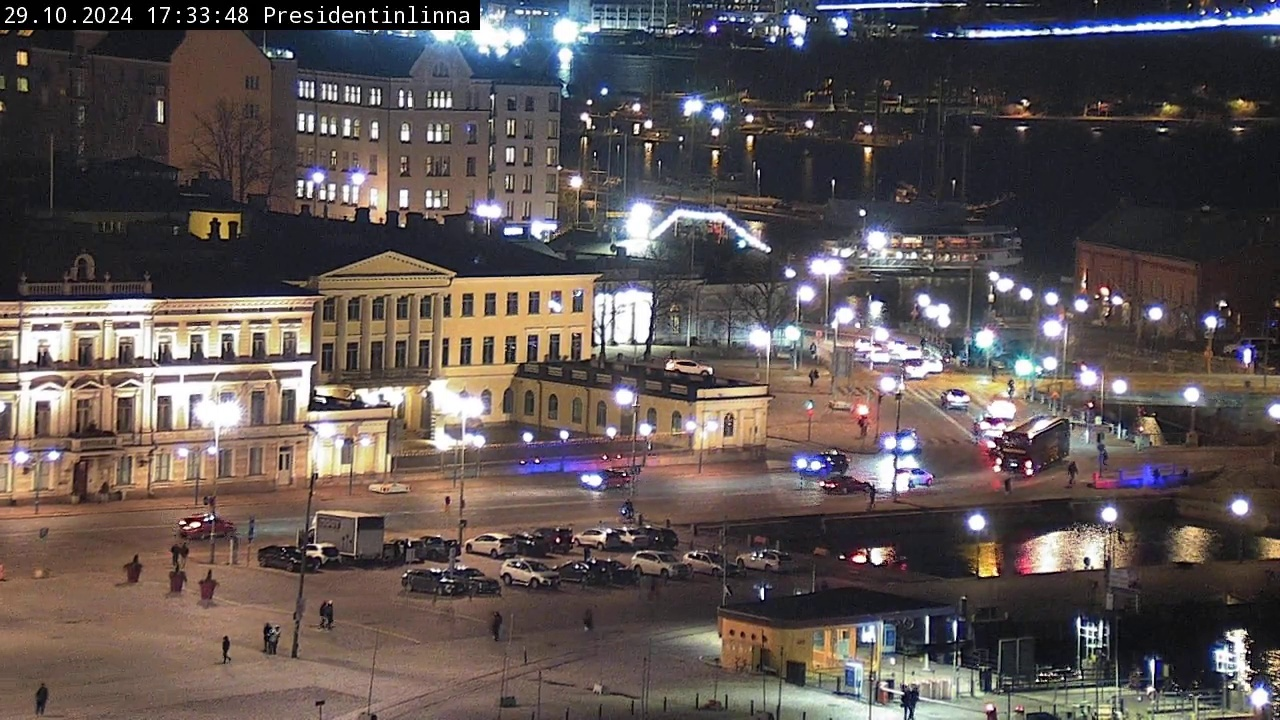

In [ ]:
#|eval: false
YouTubeLive().dump()

In [ ]:
#YouTubeLive().capture_frames()

In [ ]:
import glob

In [ ]:
files = glob.glob('../data/*.jpg')
len(files), files[0]

(9, '../data/frame_1730210769.jpg')

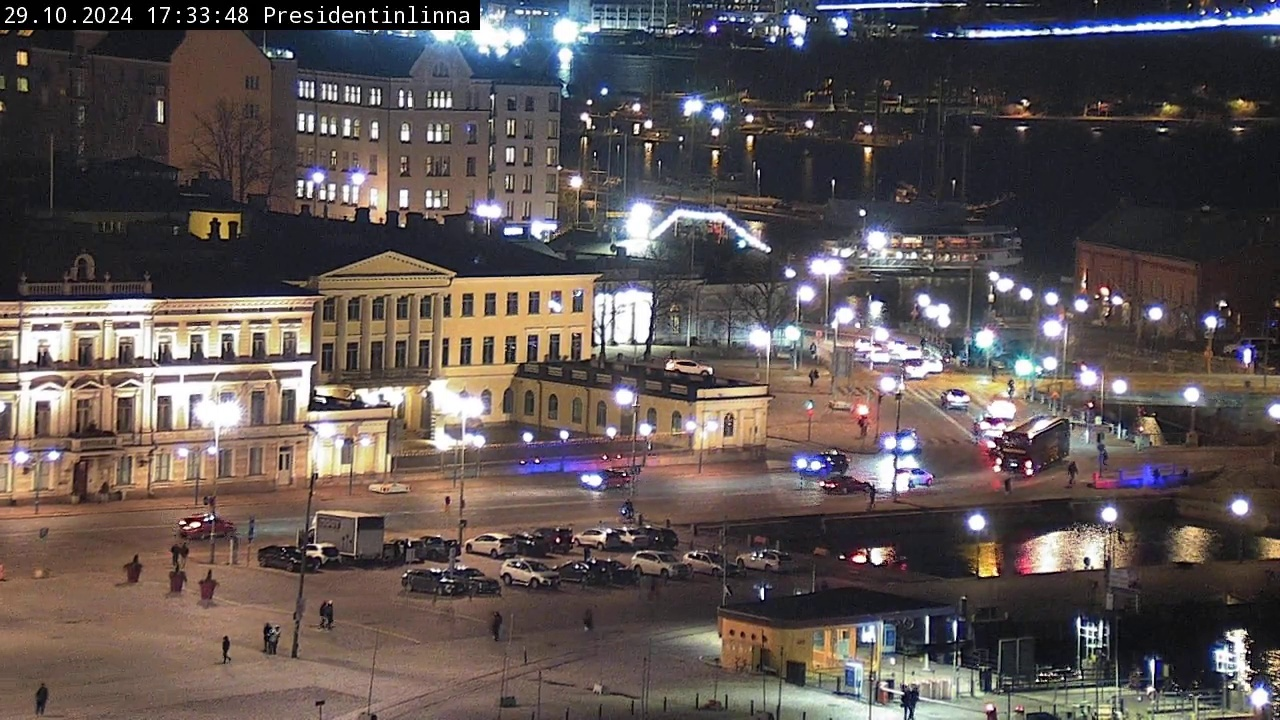

In [ ]:
from IPython.display import Image
Image(filename=files[1])

# Show image with specified rectangle

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

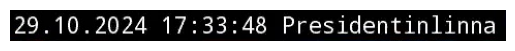

In [ ]:
image = Image.open(files[1])
rectangle_coords = (0, 0, 480, 30)
image = image.crop(rectangle_coords)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
def crop(path, crop=(0, 0, 480, 30)): return Image.open(path).crop(crop)

In [ ]:
def show_image(path):
    plt.imshow(crop(path))
    plt.axis('off')
    plt.show()

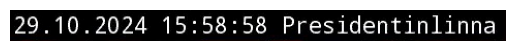

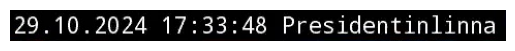

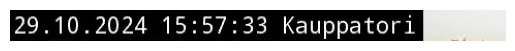

In [ ]:
for o in files[:3]:
    show_image(o)

# Extract meta data from an image file

In [ ]:
from pathlib import Path
from PIL import Image
import pytesseract
from datetime import datetime

In [ ]:
helsinki_known_places = [
    "Olympiaterminaali",
    "Etelasatama",
    #"Eteläsatama",  # fixup
    "Eteladsatama", # fixup
    "Presidentinlinna",
    "Tuomiokirkko",
    "Kauppatori",
    "Kauppator",    # fixup   
    "Torni",
    "Valkosaari",
]

In [ ]:
def known(txt, known_places):
    for o in known_places:
        print(o, "in", txt)
        if o in txt:
            return o
    raise Exception("No place specified")

In [ ]:
known("Torninnnnnn", helsinki_known_places)

Olympiaterminaali in Torninnnnnn
Etelasatama in Torninnnnnn
Eteladsatama in Torninnnnnn
Presidentinlinna in Torninnnnnn
Tuomiokirkko in Torninnnnnn
Kauppatori in Torninnnnnn
Kauppator in Torninnnnnn
Torni in Torninnnnnn


'Torni'

In [ ]:
[o.replace("Eteladsatama", "Etelasatama").replace("ä", "a") for o in ("Eteladsatama", "Eteläsatama")]

['Etelasatama', 'Etelasatama']

In [ ]:
def meta(path, known_places=helsinki_known_places, printing=False):
    "Withdraw meta data, datetime & place"
    # "04.10.2024  14:53:49  Kauppatori", Original format
    txt = pytesseract.image_to_string(crop(path)).strip()
    if printing==True: print(path, txt)
    pl = known(txt[20:], known_places)
    pl = pl.replace("Eteladsatama", "Etelasatama") # fixup
    pl = pl.replace("ä", "a")                      # fixup
    pl = pl.replace("kauppator", "kauppatori")     # fixup
    dt = datetime.strptime(txt[:19],"%d.%m.%Y %H:%M:%S")
    return dt, pl

In [ ]:
def fname(prefix, dt, pl): return f"""{prefix}{dt.strftime("%Y.%m.%d_%H:%M:%S")}_{pl}.jpg"""

In [ ]:
#|eval: false
for i, o in enumerate(glob.glob("../data/f*.jpg")):
    try:
        #show_image(o)
        dt, pl = meta(o, helsinki_known_places, True)
        print(i, fname("cap_", dt, pl))
    except Exception as e:
        pass#print(e)

../data/frame_1730210769.jpg 29.10.2024 15:58:58 Presidentinlinna
Olympiaterminaali in Presidentinlinna
Etelasatama in Presidentinlinna
Eteladsatama in Presidentinlinna
Presidentinlinna in Presidentinlinna
0 cap_2024.10.29_15:58:58_Presidentinlinna
../data/frame_1730216457.jpg 29.10.2024 17:33:48 Presidentinlinna
Olympiaterminaali in Presidentinlinna
Etelasatama in Presidentinlinna
Eteladsatama in Presidentinlinna
Presidentinlinna in Presidentinlinna
1 cap_2024.10.29_17:33:48_Presidentinlinna
../data/frame_1730210684.jpg PLPC REY AEE MCI S-hkem
Olympiaterminaali in kem
Etelasatama in kem
Eteladsatama in kem
Presidentinlinna in kem
Tuomiokirkko in kem
Kauppatori in kem
Kauppator in kem
Torni in kem
Valkosaari in kem
../data/frame_1730210981.jpg 29.10.2024 16:02:28 Eteladsatama Ie
Olympiaterminaali in Eteladsatama Ie
Etelasatama in Eteladsatama Ie
Eteladsatama in Eteladsatama Ie
3 cap_2024.10.29_16:02:28_Etelasatama
../data/frame_1730210632.jpg PR PPLPLRR LE CCI) y-htem
Olympiaterminaali

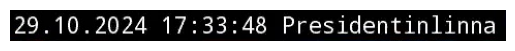

(None, '../data/frame_1730216457.jpg')

In [ ]:
show_image(files[1]), files[1]

In [ ]:
import os

In [ ]:
#os.rename("/tmp/a.txt", "/tmp/b.txt")

In [ ]:
#|eval: false
try:
    fname("cap_", *meta(files[1]))
except:
    pass

Olympiaterminaali in Presidentinlinna
Etelasatama in Presidentinlinna
Eteladsatama in Presidentinlinna
Presidentinlinna in Presidentinlinna


## Rename files with meta info

"cap_2024.10.04_14:56:49_Presidentinlinna"

"cap_2024.10.06_19:04:14_Kauppatori"

"cap_2024.10.06_20:08:29_Kauppatori"

In [ ]:
#|eval: false
for i, o in enumerate(glob.glob("../data/f*.jpg")):
    try:
        new = Path("../data")/fname("cap_", *meta(o, True))
        print(i, o, " -> ", new)
        os.rename(o, new)
    except Exception as e:
        print(o)

../data/frame_1730210769.jpg
../data/frame_1730216457.jpg
../data/frame_1730210684.jpg
../data/frame_1730210981.jpg
../data/frame_1730210632.jpg
../data/frame_1730210753.jpg
../data/frame_1730210641.jpg
../data/frame_1730210660.jpg
../data/frame_1730211141.jpg


In [ ]:
files = glob.glob("../data/*.jpg")
len(files), files[:3]

(9,
 ['../data/frame_1730210769.jpg',
  '../data/frame_1730216457.jpg',
  '../data/frame_1730210684.jpg'])

In [ ]:
files[0]

'../data/frame_1730210769.jpg'

In [ ]:
for i, o in enumerate(glob.glob("../data/f*.jpg")[:3]):
    try:
        meta(o, helsinki_known_places, True)
    except Exception as e:
        pass#print(e)

../data/frame_1730210769.jpg 29.10.2024 15:58:58 Presidentinlinna
Olympiaterminaali in Presidentinlinna
Etelasatama in Presidentinlinna
Eteladsatama in Presidentinlinna
Presidentinlinna in Presidentinlinna
../data/frame_1730216457.jpg 29.10.2024 17:33:48 Presidentinlinna
Olympiaterminaali in Presidentinlinna
Etelasatama in Presidentinlinna
Eteladsatama in Presidentinlinna
Presidentinlinna in Presidentinlinna
../data/frame_1730210684.jpg PLPC REY AEE MCI S-hkem
Olympiaterminaali in kem
Etelasatama in kem
Eteladsatama in kem
Presidentinlinna in kem
Tuomiokirkko in kem
Kauppatori in kem
Kauppator in kem
Torni in kem
Valkosaari in kem


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()